<center><a href="https://www.nvidia.cn/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>

# <font color="#76b900">**2:** LLM 架构</font>

在上一个 notebook 中，您接触了 HuggingFace &#x1F917; pipeline 的表层接口，并从接口抽象中向下深入了一层，看到了一点背后的组件是如何实现的。也就是说，您现在应该熟悉了 `preprocess -> forward -> postprocess` 的抽象，它向用户隐藏了背后的复杂性，使得我们可以轻松的使用模型。在这个 notebook 中，我们将尝试更深入的理解这项能实现推理的技术。

#### **学习目标：**

* 直观的理解分词和嵌入，尤其是数据如何进入模型以及网络可以利用输入的哪些属性。
* 理解执行序列化推理的 Transformer 编码器架构，用于实现序列到序列的过程。

## 2.1. 获取模型输入

正如我们之前所看到的，整个 pipeline 必须使用 `preprocess` 将输入转为张量，接着用 `postprocess` 将张量转为输出。再深入一点，我们可以看到 preprocess 方法依赖于 tokenizer，先假设 postprocess 也如此。现在再回到这个 pipeline：

In [1]:
from transformers import pipeline

unmasker = pipeline('fill-mask', model='bert-base-uncased')

## Testing out the tokenizer
msg = "Hello world!"
print("Tokenize:", unmasker.tokenizer.tokenize(msg))      ## See token boundaries
print("Encoding:", x := unmasker.tokenizer.encode(msg))   ## See special tokens at end
print("Decoding:", x := unmasker.tokenizer.decode(x))     ## See decoding

## Specifying multiple sentences
unmasker.tokenizer("Hello world!", "Have a great day!")

0it [00:00, ?it/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenize: ['hello', 'world', '!']
Encoding: [101, 7592, 2088, 999, 102]
Decoding: [CLS] hello world! [SEP]


{'input_ids': [101, 7592, 2088, 999, 102, 2031, 1037, 2307, 2154, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

这段代码表明 tokenizer 是一种将输入字符串转换为一系列 token 的方式。token 是一种符号化的表示，通常可以理解为一种标签。在语言建模中，token 通常是一个词、字母或其他可作为句子成份的子字符串。您将会看到，这是所有大型语言模型中最统一的部分之一，同时也可能是概念上最简单明了的。知道它们是什么以及它们如何运行还是很有必要的。

**给定字符串后，tokenizer 会通过以下组件给出响应：**

* `input_ids`：这些是构成句子的 token ID。我们提到过，token 可以是单词、标点、字母等等。就是一个个来自固定词表的条目，跟类别一样。
* `token_type_ids`：这是 BERT 作者认为有用的信息。是一个额外的标志，用于告知 BERT 这是第一个还是第二个句子。这有时会有用（是 BERT 特有的训练目标的主要部分），但您可能永远不会在实际中用到。
* `attention_mask`：稍后将讨论。它是 transformer 组件需要的输入，调节着某个特定 token 可以关注哪些其它 token。对于 BERT，这并不是必需的，但也可以指定。

我们只需要知道， `input_ids` 是我们的模型最重要的输入。考虑到这一点，我们可以直观地明白 LLM 如何处理自然语言任务：**对一串有序的 token 序列进行推理。** 一方面，这应该让人放心，因为分类是深度学习中的一项常见任务，您可能已经很熟悉了。另一方面，您可能对将类别作为输入或序列推理的过程不太熟悉。我们可以继续研究，看看语言模型能用什么直觉来理解。

## 2.2. 捕获 Token 语义

我们现在知道，自然语言推理是一个 token 序列中做推理的任务，那么我们具体要怎么做？关于类，我们应该已经有了一些直觉：

* **在输出端**，我们可以输出一组可能类别的概率分布。例如，如果我们在 `cat`、 `dog`、`bird` 中进行预测，就可以输出一个 3 值向量，其直观的含义是 `<is_cat, is_dog, is_bird>` 。对于真值，您只需使用 one-hot 编码，其中正确的项为 1，其他为 0。
* **在输入端**，我们也可以根据需要输入 one-hot 值，但更有效的策略是使用**嵌入层**，或者是一个大矩阵，用类别索引标示出要访问的行。无论选择哪种，您都将在模型架构中保留与类别相关的语义记录（在第一层的权重或矩阵的权重中）。

LLM 确实有这样的策略：

In [2]:
model = unmasker.model
dir(model)
dir(model.bert)
model.bert.embeddings
model.bert.embeddings.word_embeddings
model.bert.embeddings.position_embeddings
model.bert.embeddings.token_type_embeddings

Embedding(2, 768)

通过运行这段代码，我们可以从输出了解到这个 3 个部分：

* 词嵌入（Word Embeddings）：输入中 token 的语义向量。
* 位置嵌入（Position Embeddings）：单词位置的语义向量。
* Token 类型嵌入（Token Type Embedding）：表示 token 属于第一句还是第二句的语义向量。

请注意， `Embedding` 组件是以这种格式表达的：

```
Embedding(in_channel, out_channel)
```

从中我们可以看出 BERT 的嵌入向量是 768 维，还能知道是如何得到的。词嵌入似乎是从一个 30,522 维的向量来的（词汇表中唯一 token 的数量），位置嵌入是从 512 维来的，token 类型只有很少的几个维度。让我们继续探索。

### 探究词嵌入

我们先来看一下词嵌入：

In [3]:
import torch

tokenizer = unmasker.tokenizer

string = "Hello World From Me, my cat and my dog!"
tokens = [tokenizer.convert_ids_to_tokens(x) for x in tokenizer.encode(string)]
token_ids = torch.tensor(tokenizer(string)['input_ids'])
embeddings = model.bert.embeddings.word_embeddings(token_ids)
print(embeddings.shape)
embeddings

torch.Size([13, 768])


tensor([[ 0.0136, -0.0265, -0.0235,  ...,  0.0087,  0.0071,  0.0151],
        [-0.0043, -0.0330, -0.0217,  ..., -0.0425, -0.0127, -0.0389],
        [ 0.0244,  0.0322,  0.0024,  ..., -0.0424, -0.0054, -0.0284],
        ...,
        [-0.0149,  0.0124,  0.0091,  ..., -0.0445, -0.0193,  0.0234],
        [ 0.0298, -0.0373, -0.0356,  ...,  0.0161,  0.0192,  0.0173],
        [-0.0145, -0.0100,  0.0060,  ..., -0.0250,  0.0046, -0.0015]],
       grad_fn=<EmbeddingBackward0>)

我们希望嵌入向量能够捕捉自然语言的一些含义。为了进一步探究，我们先定义一些辅助函数：

In [4]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def cosine_similarity(x1, x2):
    """Compute cosine similarity between two vectors."""
    x1_normalized = x1 / torch.norm(x1, dim=1, keepdim=True)
    x2_normalized = x2 / torch.norm(x2, dim=1, keepdim=True)
    return x1_normalized @ x2_normalized.T

def scaled_dp_similarity(x1, x2):
    """Compute dot-product similarity between two vectors."""
    dot_product = x1 @ x2.T
    d = torch.sqrt(torch.tensor(x1.shape[-1]))
    return dot_product / d

def softmax_similarity(x1, x2):
    """Compute softmaxed dp similarity between two vectors."""
    out = scaled_dp_similarity(x1, x2)
    return torch.softmax(out, dim=1)

def plot_mtx(matrix, name='', tokens=[]):
    """Compute similarity matrix for embeddings."""
    # Plot similarity matrix
    plt.figure(figsize=(10, 8))
    label_dict = {} if tokens is None else {'xticklabels' : tokens, 'yticklabels': tokens}
    sns.heatmap(
        np.round(matrix.detach().numpy(), 3),
        annot=True, cmap='coolwarm',
        vmin=-1, vmax=1,
        **label_dict
    )
    plt.title(f"Embedding {name} Matrix")
    plt.yticks(rotation=0)
    plt.show()

通过定义这些可视化指标函数，我们可以观察到不同度量空间中嵌入的相似性：

#### **基本的余弦相似度**

运行以下代码可以计算余弦相似度：

```python
plot_mtx(cosine_similarity(embeddings, embeddings), 'Cosine Sim', tokens)
```

#### **Softmax 注意力**

您会注意到，我们得到了一个很好的归一化矩阵，但遗憾的是，向量的距离信息丢失了。
我们很快就会看到这一点被纳入架构，因此值得观察一下，当我们决定过渡到基于 softmax 的相似性时，会发生什么：

```python
plot_mtx(softmax_similarity(embeddings, embeddings), 'Softmax(x1) Sim', tokens)
```

我们看到，按行应用 softmax 后，矩阵就不再是对称的，但当您从矩阵相乘的角度来看时，它很直观的模拟了：**相较于其它 token，一个 token 对所有其它 token 的贡献有多大？** 这个形式之后将作为“注意力”出现。

您还会注意到矩阵值都很小，但我们可以增加嵌入的大小，就能看到更极化（polarizing）的相似度矩阵。

```python
plot_mtx(softmax_similarity(embeddings*10, embeddings*10), 'Softmax(x10) Sim', tokens)
```

现在把数值大小纳入了决策过程，但输出仍可控。因此当您确实想将相似性纳入优化过程时，这是一个很好的选择（后面将会讲到）。

无论如何，我们只需要记住：**“词嵌入是基于每个 token 在句子中的含义和用法学习出来的向量表示”。**

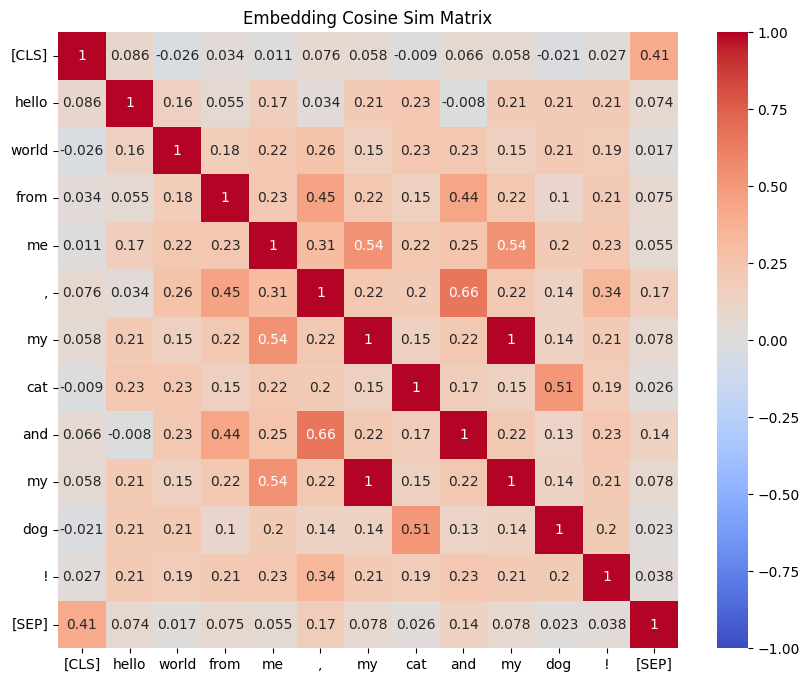

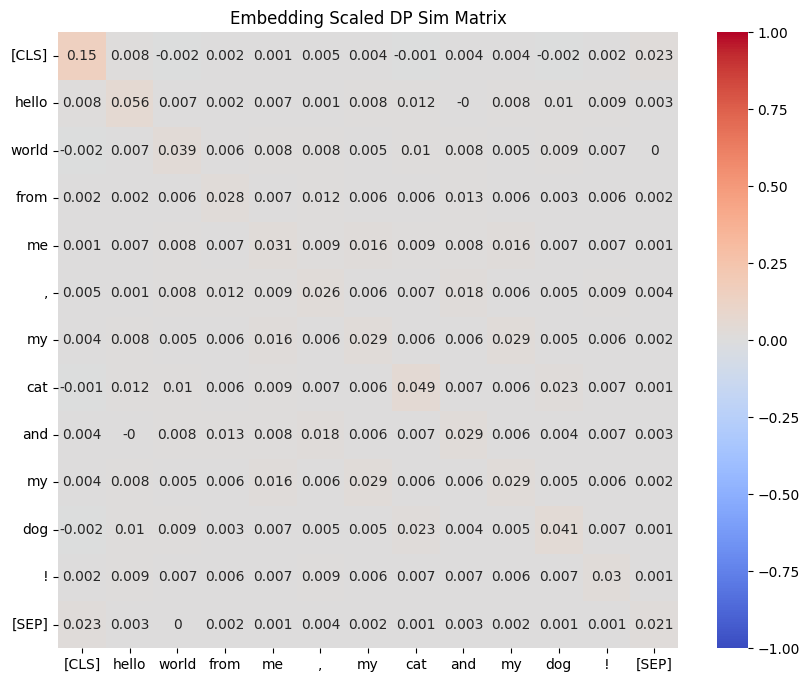

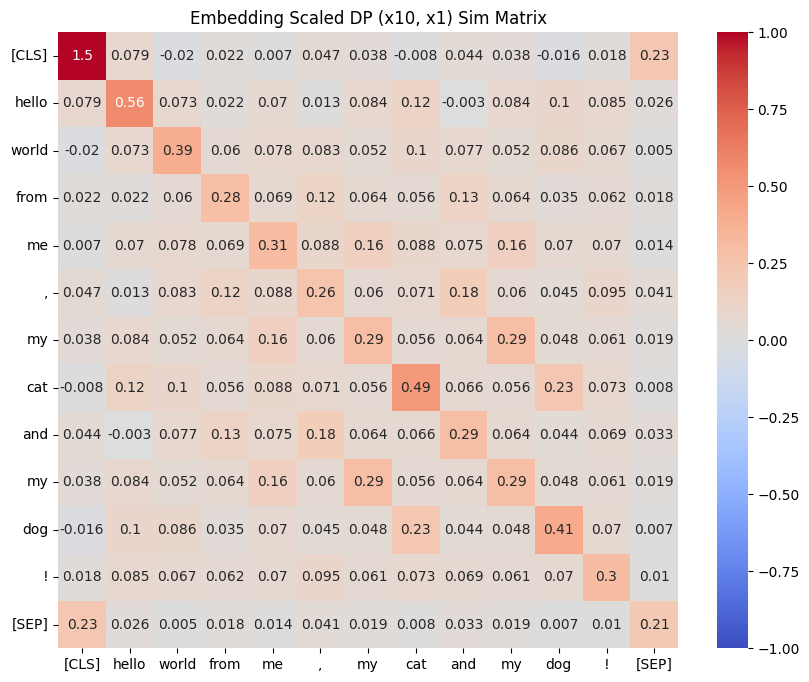

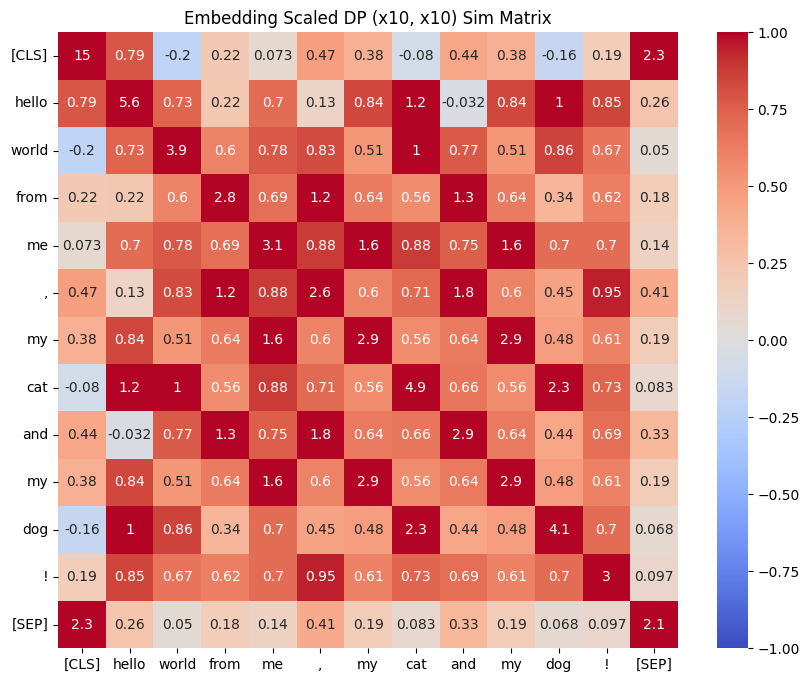

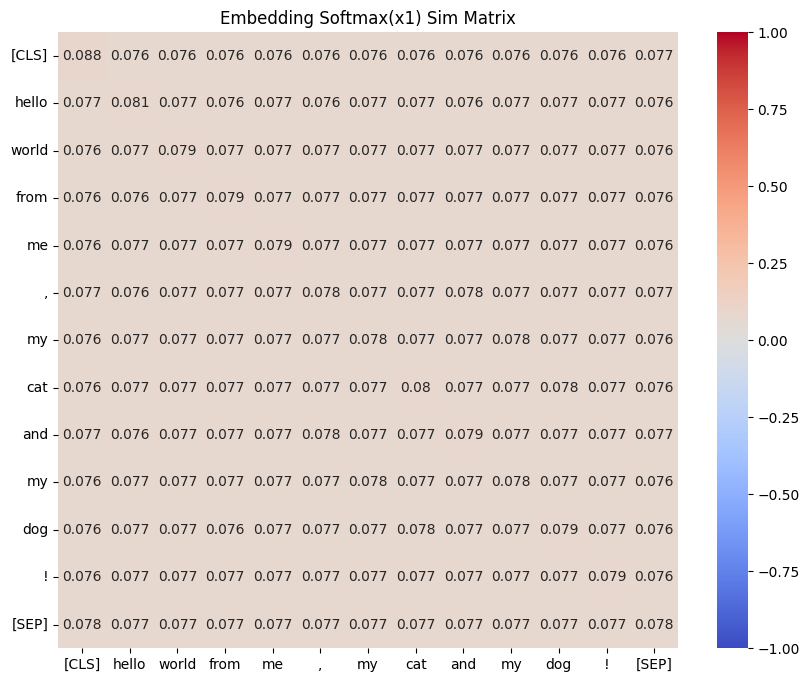

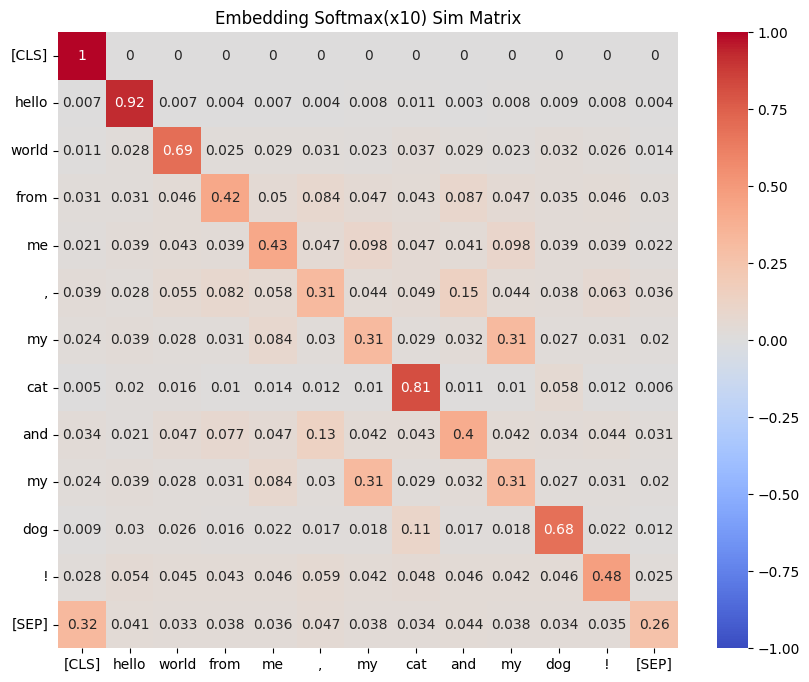

In [5]:
plot_mtx(cosine_similarity(embeddings, embeddings), 'Cosine Sim', tokens)

plot_mtx(scaled_dp_similarity(embeddings, embeddings), 'Scaled DP Sim', tokens)
plot_mtx(scaled_dp_similarity(embeddings*10, embeddings), 'Scaled DP (x10, x1) Sim', tokens)
plot_mtx(scaled_dp_similarity(embeddings*10, embeddings*10), 'Scaled DP (x10, x10) Sim', tokens)

plot_mtx(softmax_similarity(embeddings, embeddings), 'Softmax(x1) Sim', tokens)
plot_mtx(softmax_similarity(embeddings*10, embeddings*10), 'Softmax(x10) Sim', tokens)

### 探究位置嵌入

我们已经了解了词嵌入，现在来看位置嵌入：

```python
model.bert.embeddings.position_embeddings ## -> Embedding(512, 768)
```

与词嵌入不同，有一个新的输入维度：512。

这实际上对应了 BERT 模型可以接受的输入 token 数量。现在所有的语言模型的单条输入都有 token 数量限制，因此模型只能考虑最多 512 个位置。


您会注意到，与词嵌入相比，位置嵌入的余弦相似度图更加可预测和均匀，除了偶尔几处都相当一致。

**您可以通过下面的代码可视化位置嵌入矩阵的一个子集。**

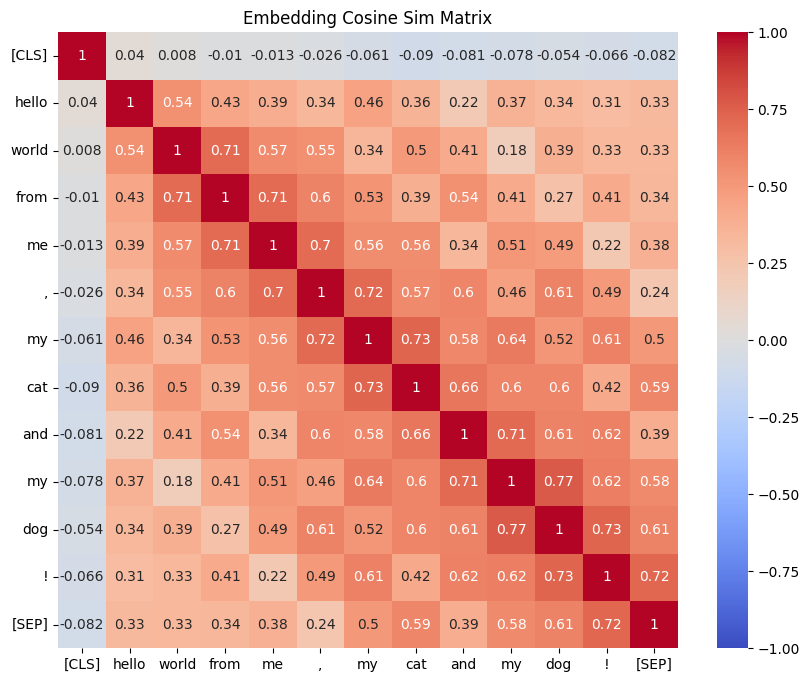

In [6]:
pos_options = torch.arange(len(tokens)) ## 0, 1, ..., n
pos_embeddings = model.bert.embeddings.position_embeddings(pos_options)
plot_mtx(cosine_similarity(pos_embeddings, pos_embeddings), 'Cosine Sim', tokens)

### **嵌入的尾声**

为了结束嵌入的讨论，最后来看 **token 类型嵌入**，它遵循着大致相同的逻辑。只是获取了句子结构的一些额外语义信息并编码。作者认为这些额外的信息是必要的，因此 BERT 整体的嵌入定义为：

`embed = WordEmbed[token] + PosEmbed[pos] + TypeEmbed[pos]`

In [7]:
model.bert.embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

最后，还包括 LayerNorm 和 Dropout 部分，它们将帮助您完成架构。简短的讨论就足以说明它们的必要性：

* [LayerNorm 层](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html)对经由其中的数据进行归一化，使得每个 minibatch 都遵循类似的分布。您可能已经在计算机视觉领域看到过 [BatchNorm](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)，逻辑是类似的，只不过现是针对层输出做归一化，而不是批。
	+ [使用批归一化和层归一化构建更好的深度学习模型 | **PineCone.io**](https://www.pinecone.io/learn/batch-layer-normalization/)
	+ [**PowerNorm** 论文](https://arxiv.org/abs/2003.07845)：包含对批/层归一化以及 LLM 应用更深入的分析
* [Dropout 层](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)在训练过程中掩掉了一些值。您可能之前看到过，是为了防止网络过度依赖某些特征。

在这正好提醒您，HuggingFace 是一个开源平台！虽然它非常庞大，但您只要知道怎么去检索就会很好用了。现在，我们通过 [`transformers/models/bert/modeling_bert.py`](https://github.com/huggingface/transformers/blob/0a365c3e6a0e174302debff4023182838607acf1/src/transformers/models/bert/modeling_bert.py#L180C11-L180C11) 来看看这一切是怎么串到一起的。阅读源代码有助于解答技术细节上模糊不清的地方，就比如：“这里用的是加法还是拼接”（是加法），或者：“为了使模型能真正运行起来，是否需要其它必要的步骤”（是的）。请看看源代码，尝试感受一下让模型执行推理实际上需要的信息是多么的少。

## 2.3. 从 token 级别的推理到文章级别的推理

**总结一下 LLM 输入的要点：**

* 我们将段落作为一个有序的 token 序列输入，序列是通过将字符串传递给 tokenizer 得到的。
* 我们训练与 token 特征（含义、位置等）一致的嵌入，并将它们合并在一起（在这里，指的就是将它们直接相加）。

**对于如何根据数据进行推理，有一些显而易见的选项：**

* **按 token 推理**：把每个 token 独立处理（就像分类任务那样）。
	+ **问题：** Token 需要理解句子中的其它 token 上下文。
* **密集层方法**：将序列的所有 token 合并起来，作为一个整体推理。
	+ **问题：** 这样会构建出一个不可追踪的神经网络。

LLM 给出的是一个折中的解决方案：
> 允许**对每个 token *（token 级推理）***执行推理，但也允许网络**将序列作为整体*（序列级推理）***，组合多个 token 一起进行推理！这就是 **transformer** 发挥作用的地方了！

这时我们就需要 **transformer** 了！

### **Transformer 注意力机制**

**Transformer** 是在 2017 年的论文 [*Attention Is All You Need*](https://arxiv.org/abs/1706.03762) 中介绍的用于语言任务推理的架构，现在已几乎存在于所有最先进语言建模的架构中。此架构使用**注意力机制**为序列中的 token 互相交流语义信息提供了途径。

它的机制如下：如果嵌入中存在语义和位置信息，我们可以训练一个从嵌入到 $K$、$Q$、$V$ 三个语义空间的映射：

* `K（Key）` 和 `Q（Query）` 是相似度函数的参数（回顾一下缩放的 softmax 注意力），用于度量输入中任意一对序列条目之间应分配多少权重（或注意力）。
	+ 在实践中，每个 transformer 的输入是原始 token 的隐嵌入。
* `V（Value）` 是需要传到下一个组件的信息，并用 `SoftmaxAttention(Key, Query)` 作为权重，以生成具有位置和语义信息的输出。

**换言之：** 给定一个包含 $d_k$ 个带有丰富语义/位置信息元素的嵌入（$S$） 和三个对序列各项做运算的密集层（$K$，$Q$ 和 $V$），我们就可以训练出一个能用前向方程来做语义/位置预测的神经网络：

$$\text{Self-Attention} = \text{SoftmaxAttention}(K_s, Q_s) \cdot V_s$$
$$= \frac{K_s Q_s ^T}{\sqrt{d_k}}V_s$$

实际上我们就得到了：
- **$K(E),V(E),Q(E)$:** 从 $E$ 得出的 3 个个同的嵌入。
- **$\sigma(A)$:** 每个嵌入式如何与其它嵌入相联系的。
- **$\sigma(A)V$:** 同时带有 $V$ 和注意力。

<div><img src="imgs/attention-logic.png" width="1000"/></div>

这种注意力被称为自注意力，因为 `Key`，`Query` 以及 `Value` 都是从同一序列推理出来的。后面将会讲到其它类型的注意力。

### 在 BERT 编码器中观察注意力

现在我们已经回顾了自注意力的工作原理，让我们查看 BERT 编码器，了解如何处理嵌入：

In [8]:
unmasker.model.bert.encoder

BertEncoder(
  (layer): ModuleList(
    (0-11): 12 x BertLayer(
      (attention): BertAttention(
        (self): BertSdpaSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (output): BertSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (intermediate): BertIntermediate(
        (dense): Linear(in_features=768, out_features=3072, bias=True)
        (intermediate_act_fn): GELUActivation()
      )
      (output): BertOutput(
        (dense): Linear(in_features=3072, out_features=768, bias=True)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

我们来概括的谈谈这些组件，实现细节将会非常深入：

* `BertSdpa(ScaledDotProductAttention)SelfAttention`：此组件用向量序列（我们把它叫做 `x`）作为输入，并通过 `query(x)`，`key(x)`，`value(x)` 分别得到 `Q`，`K`，`V` 组件。由于这些都是 $768$ 维的向量，因此在转置后是乘法兼容的，该层的注意力计算只做了一些关键的调整：

	+ **多头注意力（Multi-Headed Attention）：** 是将 $K$、$Q$、$V$ 沿嵌入维度进行切片，得到维度为 $768/12=64$ 的 12 个切片。这将为我们提供 12 种不同的注意力结果，允许网络以不同的方式分配注意力。而最后，只需按嵌入维度拼接起来，就回到了 768 维的向量。
	+ **掩码注意力（Masked Attention）：** 对 BERT 来说不太有用，但解释了 `attention_mask` 是在做什么。实际上这是一个布尔值掩码，表示“我是否应该给注意力加上负无穷”，用于防止模型将注意力放到不应关注的地方。推理的时候，除非存在填充 token，否则这通常并不重要。使用现成的流程进行推理时，大多数情况下可以假设流程中已经处理好了注意力掩码。
	+ **残差连接（Residual Connections）：** 为了帮助网络让 token 级别的信息能一直传播下去（并改善整体的梯度流），大多数架构都在 transformer 组件加上了残差连接。
* `BertSelfOutput -> BertIntermediate -> BertOutput` ：这些都是 token 级的密集层，包括非线性激活和一些用于归一化的 `LayerNorm` / `Dropout` 层。因此，序列中的每个元素都经由 MLP 进行如下维度转化变成新的表达：$768 \to 768 \to 3072 \to 768$。

实际上，一共有 12 个这样的模型，一个接一个地堆叠在一起！还不错，对吧？

<div><img src="imgs/bert-construction.png" width="800"/></div>

### 可视化注意力机制的工作过程

我们可以通过指定 `output_attentions=True` 来请求在每个 `SelfAttention` 层计算的实际注意力值：

In [9]:
import torch

## Tokenization Efforts
string = "Hello Mr. Bert! How is it [MASK]?"
input_tensors = unmasker.preprocess(string)
input_ids = unmasker.tokenizer.encode(string)
input_tokens = unmasker.tokenizer.convert_ids_to_tokens(input_ids)

## Encoding Efforts
embeddings = unmasker.model.bert.embeddings(input_tensors['input_ids'])
x = unmasker.model.bert.encoder(embeddings, input_tensors['attention_mask'], output_attentions=True)

print("From encoder.forward():")
for k,v in x.items():
    v = v if hasattr(v, "shape") else torch.stack(v)
    print(f" > '{k}' : {v.shape}")

From encoder.forward():
 > 'last_hidden_state' : torch.Size([1, 12, 768])
 > 'attentions' : torch.Size([12, 1, 12, 12, 12])


为了可视化，我们用 [`BertViz` 包](https://github.com/jessevig/bertviz) 在交互式网格中显示最后一次前向传播的注意力！您可以试试其它输入，看看会有什么变化。

* 当 token 数量增加时，维度会发生什么变化。
* 连接发生了什么变化，看看是否有任何值得注意的模式。
* 您觉得为什么 CLS 和 SEP token 会在许多注意力头中被分配了如此大的注意力权重？

In [10]:
from bertviz import model_view

model_view(x['attentions'], input_tokens)  # Display model view

<IPython.core.display.Javascript object>

# <font color="#76b900">**总结**</font>

现在，我们已经直观的理解了模型推理文本的原理：

* 嵌入 token 的语义和位置信息。
* 基于 token 进行推理，重点关注当前 token，并稍微考虑序列中的其它 token。

这几点比较容易理解，并且在实际应用中效果很好，我们与每个模型交互时都依赖于这种直觉。

**在下一节中，我们将详细了解它们的实际运用方式，也看看我们还能用它们做点什么！**

In [11]:
## Please Run When You're Done!
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}